# Libraries

In [ ]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from xgboost import XGBClassifier, plot_importance

from numpy.random import seed
seed(1)


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load the dataset


In [ ]:
!rm -r timeseries # Reload github repository


if not os.path.isdir('./anomalydetection'):
  !git clone https://github.com/lindaludovisi/Rare-Event-Classification-in-Multivariate-Time-Series.git
  !mv 'Rare-Event-Classification-in-Multivariate-Time-Series' 'timeseries' 
os.chdir('timeseries') # Change working directory

Cloning into 'Rare-Event-Classification-in-Multivariate-Time-Series'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


# Data Exploration

In [ ]:
df_raw = pd.read_excel('processminer-rare-event-mts.xlsx')
df_raw.head()

,time,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
0,1999-05-01 00:00:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,-0.038189,0.877951,-0.052959,-13.306135,0.101068,0.041800,0.199901,-2.327329,-0.944167,3.075199,0.123154,-0.104334,-0.570710,-9.784456,0.355960,15.842819,-0.451973,-0.105282,96,-134.27786,0.058726,-0.021645,9.366755,0.002151,-69.187583,4.232571,-0.225267,-0.196872,-0.072449,-0.103732,-0.720746,-5.412436,76.679042,-0.632727,1351.63286,-0.657096,-0.434947,-108.77597,0.084856,10.210182,11.295155,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,1999-05-01 00:02:00,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,-0.038189,0.873273,-0.014244,-13.306135,0.101108,0.041447,0.304313,-2.340627,-0.939994,3.075199,0.123154,-0.104334,-0.574861,-9.784456,0.360160,16.491684,-0.450450,-0.092430,96,-134.48019,0.058759,-0.004579,9.350215,0.002149,-68.585197,4.311490,-0.225267,-0.196872,-0.059103,-0.083895,-0.720746,-8.343222,78.181598,-0.632727,1370.37895,-0.875629,-1.125819,-108.84897,0.085146,12.534340,11.290761,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,1999-05-01 00:04:00,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,-0.018352,1.004910,0.065150,-9.619596,0.101148,0.041095,0.252839,-2.353925,-0.935824,3.075199,0.123154,-0.104334,-0.579013,-9.784456,0.364356,15.972885,-0.448927,-0.097144,96,-133.94659,0.058791,-0.084658,9.037409,0.002148,-67.838187,4.809914,-0.225267,-0.186801,-0.048696,-0.073823,-0.720746,-1.085166,79.684154,-0.632727,1368.12309,-0.037775,-0.519541,-109.08658,0.085436,18.582893,11.286366,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,1999-05-01 00:06:00,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,-0.008280,0.930037,-0.067199,-15.196531,0.101188,0.040742,0.072873,-2.367223,-0.931651,3.075199,0.123154,-0.104334,-0.583165,-9.784456,0.368556,15.608688,-0.447404,-0.160073,96,-134.00259,0.058824,-0.055118,9.020625,0.002146,-67.091148,5.308343,-0.225267,-0.186801,-0.047017,-0.063752,-0.720746,6.172891,81.186702,-0.632727,1365.69145,-0.987410,0.674524,-109.56277,0.085726,17.719032,11.281972,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,1999-05-01 00:08:00,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,-0.008280,0.828410,-0.018472,-14.609266,0.101229,0.040390,0.171033,-2.380521,-0.927478,3.075199,0.123154,-0.104334,-0.587316,-9.784456,0.372756,15.606125,-0.445879,-0.131630,96,-133.14571,0.058856,-0.153851,9.344233,0.002145,-65.991813,5.806771,-0.225267,-0.186801,-0.057088,-0.063752,-0.720746,-3.379599,82.689258,-0.632727,1363.25786,-0.238445,-0.063044,-110.03891,0.086016,16.855202,11.277577,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [ ]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 63 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    18398 non-null  datetime64[ns]
 1   y       18398 non-null  int64         
 2   x1      18398 non-null  float64       
 3   x2      18398 non-null  float64       
 4   x3      18398 non-null  float64       
 5   x4      18398 non-null  float64       
 6   x5      18398 non-null  float64       
 7   x6      18398 non-null  float64       
 8   x7      18398 non-null  float64       
 9   x8      18398 non-null  float64       
 10  x9      18398 non-null  float64       
 11  x10     18398 non-null  float64       
 12  x11     18398 non-null  float64       
 13  x12     18398 non-null  float64       
 14  x13     18398 non-null  float64       
 15  x14     18398 non-null  float64       
 16  x15     18398 non-null  float64       
 17  x16     18398 non-null  float64       
 18  x17   

* Time is recorded every 2 minutes
* Dataset is made of 62 features (time, x1 --> x61)  + 1 target (y)
* There are no missing values
* Features x28, x61 are not continuous variables. x61 is a binary variable, and x28 is a categorical variable.

In [ ]:
df_raw.describe()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
count,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000,18398.000000
mean,0.006740,0.011824,0.157986,0.569300,-9.958345,0.006518,2.387533,0.001647,-0.004125,-0.003056,-0.002511,-0.011166,0.014964,1.418065,0.003222,0.001107,-0.075376,0.138210,0.105010,0.463652,-0.001578,0.076673,-0.036124,-0.088743,-0.393265,0.635612,0.048185,-0.006214,100.141646,7.054580,0.003785,-0.000296,-0.400527,0.000090,4.525465,0.050165,-0.001182,-0.021693,-0.004367,-0.003903,-0.036444,-0.006410,0.266766,0.070846,403.959326,0.090221,0.032000,-0.983876,0.002474,5.051040,0.602553,-3.357339,0.380519,0.360246,0.173708,2.379154,9.234953,0.233493,-0.001861,-0.061522,0.001258,0.001033
std,0.081822,0.742875,4.939762,5.937178,131.033712,0.634054,37.104012,0.108870,0.075460,0.156047,0.106526,3.220442,2.381027,45.801703,0.162565,0.039619,2.279129,2.149115,1.947106,4.895061,0.302746,1.317702,0.833010,5.961967,4.734010,59.847503,0.995501,0.450702,17.642120,130.112284,0.088395,0.118237,62.478214,0.001070,75.696562,1.893939,0.268737,0.279232,0.202733,0.178014,0.967533,4.842681,57.751465,4.961169,2155.005113,4.023940,0.756007,68.300305,1.099839,107.164471,6.454156,348.256716,6.211598,14.174273,3.029516,67.940694,81.274103,2.326838,0.048732,10.394085,0.004721,0.032120
min,0.000000,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,-0.120087,-0.098310,-26.191152,-22.223434,-164.897670,-0.028775,-0.623730,-19.901141,-14.081542,-18.313006,-156.929680,-1.520451,-7.106501,-3.228480,-236.783570,-12.411317,-579.412730,-2.333210,-1.807603,51.000000,-228.302190,-0.262892,-0.539117,-608.372930,-0.001809,-508.638880,-4.764285,-0.945199,-1.706928,-0.147118,-0.163853,-5.700757,-58.183432,-39.592770,-0.632727,-3768.476500,-2.753967,-2.453742,-174.148590,-5.484846,-450.744260,-23.448985,-3652.989000,-187.943440,-1817.595500,-8.210370,-230.574030,-269.039500,-12.640370,-0.149790,-100.810500,-0.012229,0.000000
25%,0.000000,-0.405681,-2.158235,-3.537054,-111.378372,-0.446787,-24.345268,-0.058520,-0.051043,-0.059966,-0.048260,-0.268052,-0.188745,-28.720384,-0.028775,-0.019850,-0.260779,-1.329108,-1.321521,-3.926967,0.123154,-0.408417,-0.604798,-4.784303,-4.291578,4.265595,-0.750072,-0.246588,84.000000,-66.014560,-0.083071,-0.065516,4.077524,-0.000990,-55.730629,-0.760257,-0.165146,-0.186801,-0.086997,-0.103732,-0.230619,-2.987541,-39.051126,-0.632727,-637.123493,-0.778840,-0.434027,-32.335066,-0.011280,-64.577736,-3.883678,29.984624,-3.672684,-1.928166,0.487780,-40.050046,-45.519149,-1.598804,0.000470,0.295023,-0.001805,0.000000
50%,0.000000,0.128245,-0.075505,-0.190683,-14.881585,-0.120745,10.528435,-0.009338,-0.000993,-0.030057,-0.018352,0.367737,0.511975,0.387522,-0.028775,0.002187,0.201777,-0.527784,-0.627076,3.075199,0.123154,-0.104334,-0.230342,-0.205408,0.220845,7.586258,-0.181393,0.107681,96.000000,27.755752,0.060843,-0.002557,5.846613,0.000311,25.756509,0.037213,-0.005229,-0.047026,-0.054631,-0.053986,0.269274,-0.077903,-36.681261,-0.632727,912.977579,-0.416882,-0.075129,31.360231,0.0

In [ ]:
df_raw[df_raw.y==0].describe()

# Here we notice that variable x61 is freezed

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61
count,18274.0,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.000000,18274.0
mean,0.0,0.011198,0.194998,0.626211,-10.139593,0.006840,2.489880,0.001483,-0.004143,-0.003368,-0.002538,-0.001687,0.015571,1.507474,0.003330,0.000916,-0.075127,0.145977,0.114138,0.520453,-0.001713,0.074956,-0.034874,-0.084612,-0.402279,0.595253,0.050867,-0.005277,100.141513,7.476524,0.003794,-0.000244,-0.439515,0.000090,4.740184,0.053507,-0.000806,-0.021239,-0.004506,-0.003866,-0.035151,-0.004893,0.104313,0.074325,405.354110,0.092995,0.031199,-0.887295,0.001874,4.940570,0.616275,-3.583815,0.401567,0.458541,0.183983,2.454428,9.401764,0.236905,-0.001881,-0.069369,0.001252,0.0
std,0.0,0.741833,4.912832,5.898330,130.983772,0.633845,36.987546,0.108664,0.075172,0.155036,0.106395,3.193036,2.382700,45.785124,0.163078,0.035457,2.286096,2.119743,1.915097,3.604284,0.298693,1.314300,0.832455,5.696896,4.660283,60.045715,0.995089,0.449599,17.654308,130.056219,0.088429,0.118192,62.687710,0.001070,75.525937,1.891017,0.268897,0.279266,0.202314,0.178007,0.967207,4.838158,57.637932,4.975609,2154.127266,4.035792,0.750001,68.280684,1.100085,107.076063,6.446876,349.425443,6.052476,4.612143,3.023366,67.891696,81.289542,2.324591,0.048760,10.428501,0.004718,0.0
min,0.0,-3.787279,-17.316550,-18.198509,-322.781610,-1.623988,-279.408440,-0.429273,-0.451141,-0.120087,-0.098310,-26.191152,-22.223434,-164.897670,-0.028775,-0.623730,-19.901141,-6.512555,-8.720427,-4.932857,-1.520451,-7.106501,-1.226466,-12.382189,-12.411317,-579.412730,-2.333210,-1.807603,51.000000,-228.302190,-0.262892,-0.539117,-608.372930,-0.001809,-508.638880,-4.764285,-0.945199,-1.706928,-0.147118,-0.163853,-5.700757,-58.183432,-39.592770,-0.632727,-3768.476500,-2.753967,-2.453742,-174.148590,-5.484846,-450.744260,-23.421153,-3652.989000,-16.555008,-14.211369,-8.210370,-230.574030,-269.039500,-4.888661,-0.149790,-100.810500,-0.012229,0.0
25%,0.0,-0.405828,-2.123012,-3.477843,-111.428897,-0.446864,-23.687049,-0.058658,-0.050880,-0.059966,-0.048260,-0.267352,-0.186971,-28.623365,-0.028775,-0.019811,-0.258960,-1.327165,-1.321521,-3.926967,0.123154,-0.407174,-0.603193,-4.784303,-4.319807,4.273087,-0.748123,-0.245156,84.000000,-65.387218,-0.083058,-0.065467,4.079737,-0.000990,-54.987197,-0.760257,-0.165146,-0.186801,-0.086997,-0.103732,-0.230619,-2.987541,-39.056776,-0.632727,-636.538532,-0.776767,-0.434027,-32.181533,-0.011030,-64.776947,-3.878307,29.984624,-3.672684,-1.933476,0.492208,-39.882046,-45.399116,-1.598804,0.000473,0.295016,-0.001808,0.0
50%,0.0,0.128147,-0.060635,-0.161470,-14.940988,-0.120699,10.585686,-0.009338,-0.000993,-0.030057,-0.018352,0.369727,0.515908,0.578974,-0.028775,0.002185,0.203242,-0.527784,-0.625824,3.075199,0.123154,-0.104334,-0.230342,-0.210931,0.215966,7.584580,-0.179517,0.108503,96.000000,28.257568,0.060854,-0.002460,5.852778,0.000312,25.890542,0.040112,-0.005229,-0.047026,-0.054814,-0.053986,0.269274,-0.076255,-36.701870,-0.632727,913.041059,-0.416522,-0.074763,31.433961,0.050035,18.958565,0.065663,29.984624,0.294846,0.144222,0.712452,17

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4be3ea3090>,
      dtype=object)

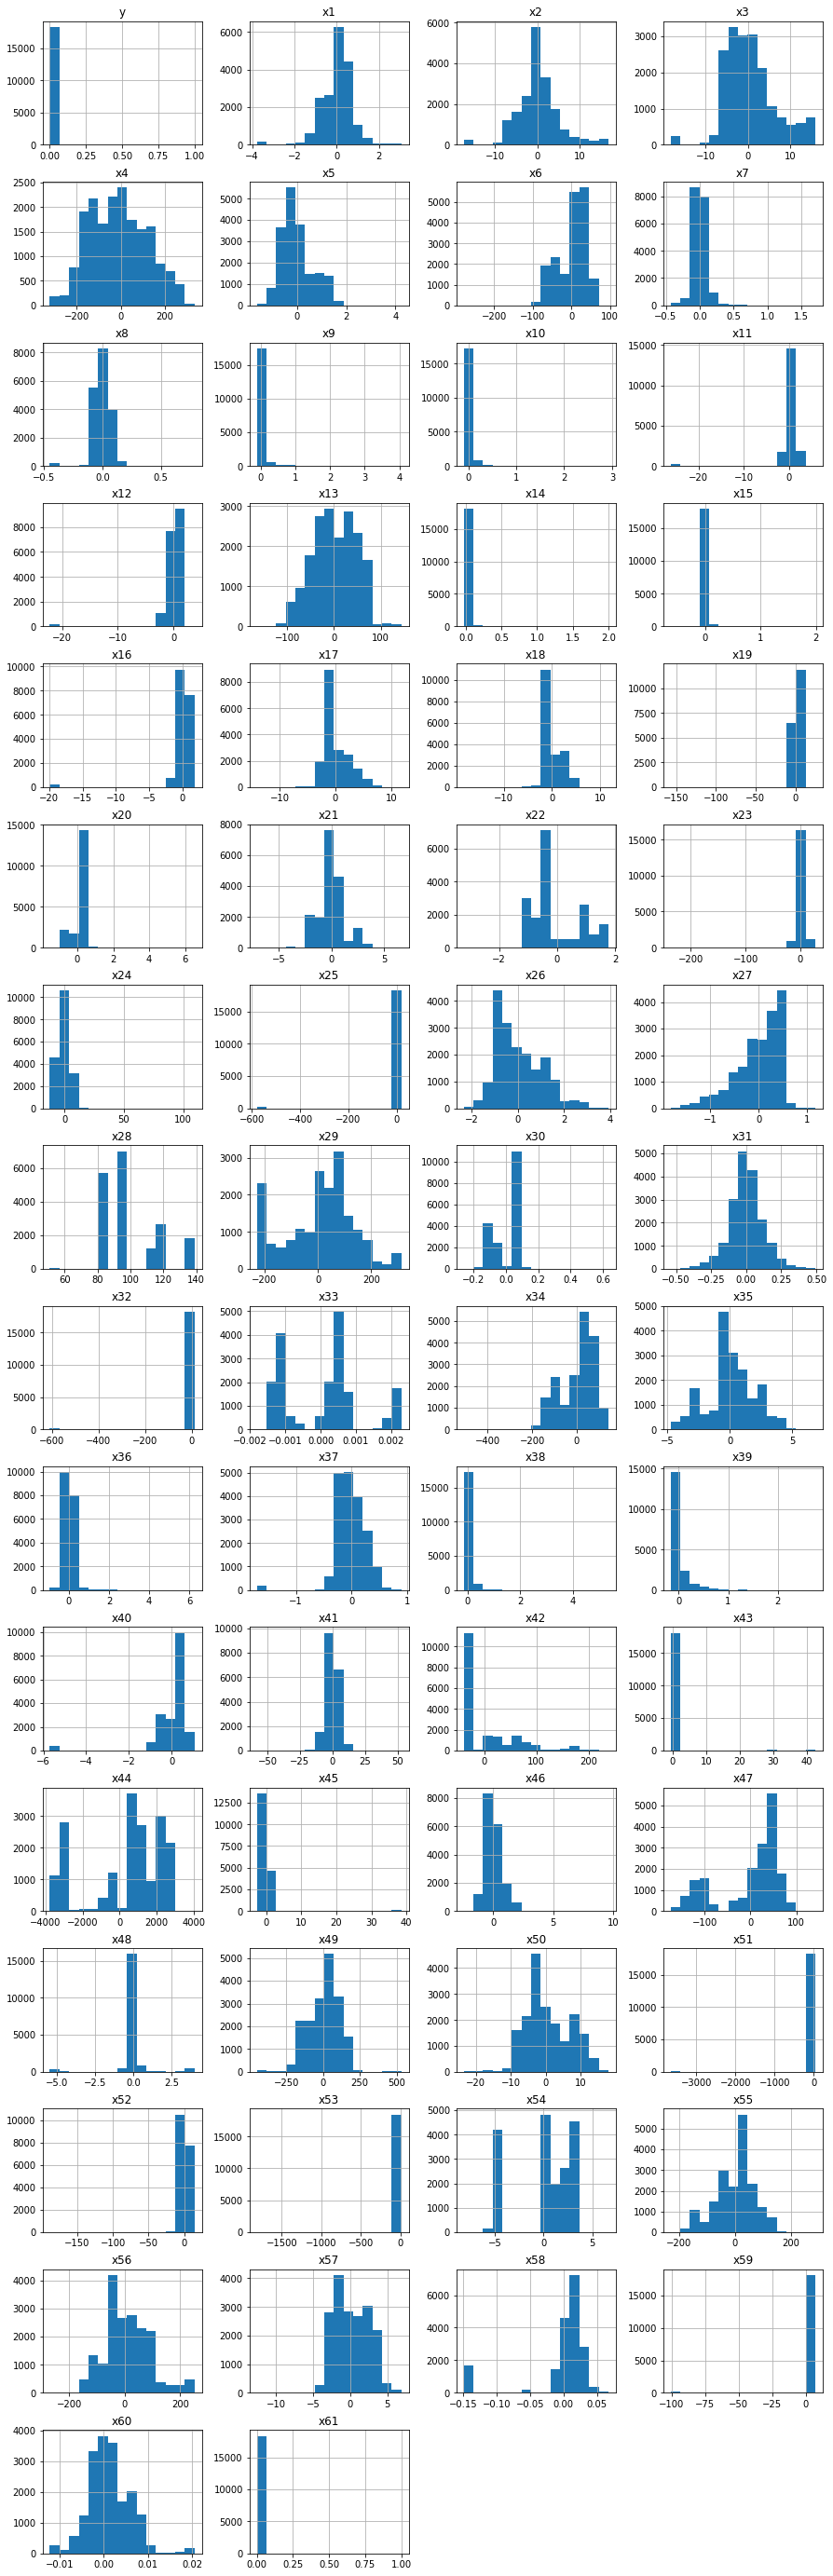

In [ ]:
df = df_raw.copy()
'''
df['x60'].loc[df.y==0].hist()
plt.show()
'''
df.hist(bins=15, figsize=(15, 50), layout=(16, 4))

Here we notice that:
* range of values are different: **standardization is needed**
* x28 is categorical (shown below)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


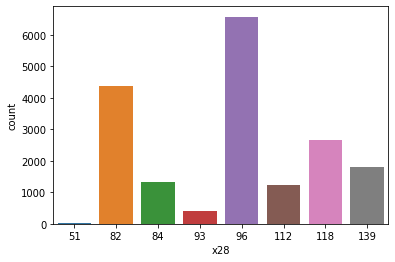

In [ ]:
# Plot the categorical variable

sns.countplot(df['x28'])

## Correlation matrix

Looking for linear relationship between variables.

Also try to generate a new df by reducing dimensions using PCA.

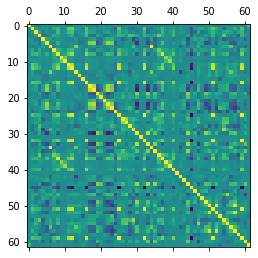

In [ ]:
plt.matshow(df.corr())
plt.show()

Text(0.5, 1.05, 'Correlation Matrix')

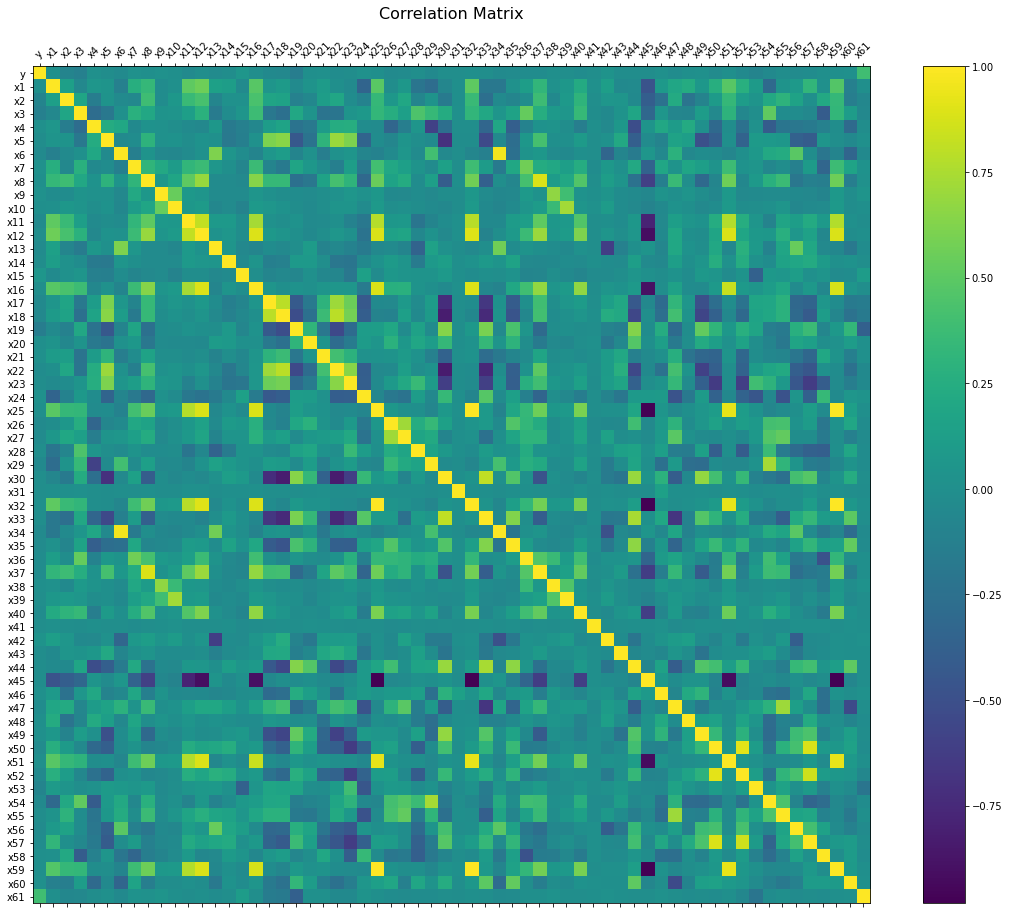

In [ ]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=16)

Correlated variables:
* x6 with x34 (+)
* x12 with x16, x25, x32, x51, x59 (+)
* x12 with x45 (-)
* x18 with x30 (-), x22 (+)
* x22 with x30 (-)

So we remove x34, x16, x25, x32, x51, x59, x45, x30, x22

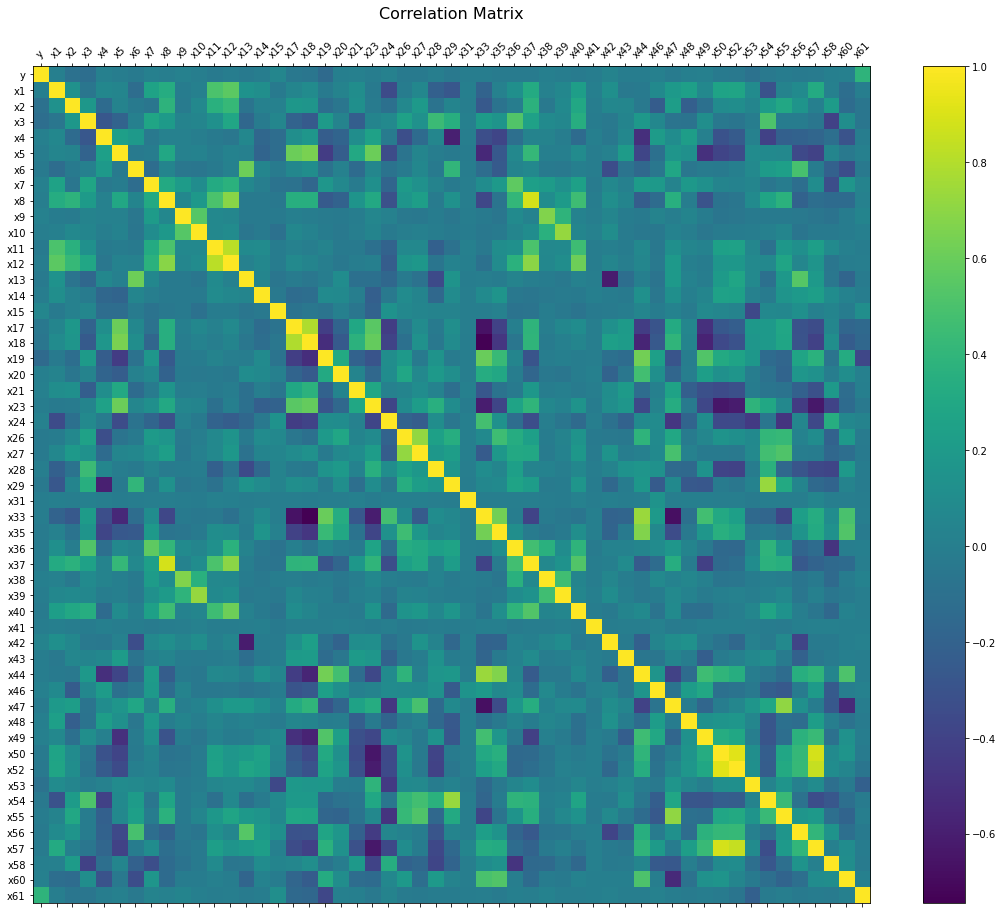

In [ ]:
df_rmv  = df.drop(columns = ['x34', 'x16', 'x25', 'x32', 'x51', 'x59', 'x45', 'x30', 'x22'])

f = plt.figure(figsize=(19, 15))
plt.matshow(df_rmv.corr(), fignum=f.number)
plt.xticks(range(df_rmv.select_dtypes(['number']).shape[1]), df_rmv.select_dtypes(['number']).columns, fontsize=10, rotation=45)
plt.yticks(range(df_rmv.select_dtypes(['number']).shape[1]), df_rmv.select_dtypes(['number']).columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=16);

#df = df_rmv.copy()

## Target Distribution

There are **18274** - 0 label, and **124** - 1 label

In [ ]:
perc = df.y.value_counts()[1] /(df.y.value_counts()[0] + df.y.value_counts()[1])
print(f"Percentage of 1 label is : {perc}")
print(f"There are {df.y.value_counts()[1]} samples labeled as 1")

Percentage of 1 label is : 0.006739863028590064
There are 124 samples labeled as 1


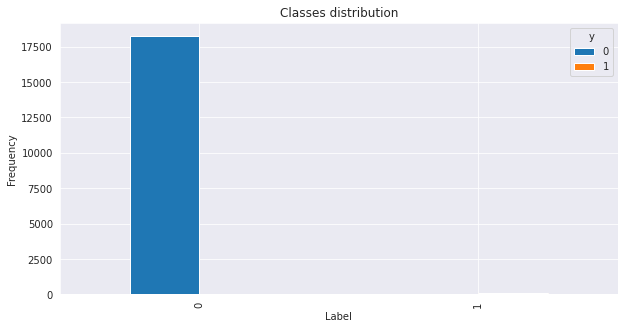

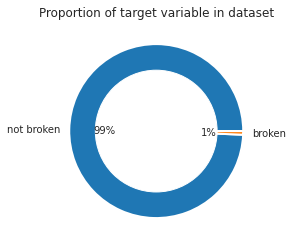

In [ ]:
#@title ####> Show code

with sns.axes_style("darkgrid"):
  size = len(df.columns)
  val='y'
  pd.crosstab(df[val],df.y).plot(kind="bar",figsize=(10,5) )
  plt.title('Classes distribution')
  plt.xlabel('Label')
  plt.ylabel('Frequency')
  plt.show()



  plt.pie(df["y"].value_counts().values,
          labels=["not broken","broken"],
          autopct="%1.0f%%",wedgeprops={"linewidth":2,"edgecolor":"white"})
  my_circ = plt.Circle((0,0),.7,color = "white")
  plt.gca().add_artist(my_circ)
  plt.subplots_adjust(wspace = .2)
  plt.title("Proportion of target variable in dataset")
  plt.show()

# Feature Engineering

The objective of this rare-event problem is to predict a sheet-break before it occurs. We will try to predict the break 4 minutes in advance. To build this model, we will shift the labels 2 rows up (which corresponds to 4 minutes)

if row n is positively labeled,
* Make row (n-2) and (n-1) equal to 1. This will help the classifier learn up to 4 minute ahead prediction.
* Delete row n. Because we do not want the classifier to learn predicting a break when it has happened.

In [ ]:
# For each n (downtime event) ...
# Make row n-2 and n-1 equal to 1 
df['y_1'] = df['y'].shift(-1)
df['y_2'] = df['y'].shift(-2)
# Delete row n (which corresponds to downtime event)
df = df.loc[df.y==0] 
# Update 'y' row
df['y'] = df.apply(lambda x: 1 if ((x['y_1'] == 1) | (x['y_2'] == 1)) else 0, axis=1)

In [ ]:
perc = df.y.value_counts()[1] /(df.y.value_counts()[0] + df.y.value_counts()[1])
print(f"The percentage of samples labeled as 1 is now: {perc}")

The percentage of samples labeled as 1 is now: 0.013516471489547991


In [ ]:
# Remove time column, y_1, y_2 and the categorical column x61 (does not add info on 0 label)
df = df.drop(['time', 'x61', 'y_1', 'y_2'], axis=1)

## *SMOTE* (not using at the moment)

In [ ]:
# Create an instance of SMOTE 
oversample = SMOTE(random_state=42)

# Autoencoder

 This type of approach aims to learn some low-dimensional feature representation space on which the given data instances can be well reconstructed. This is a widely-used
technique for data compression or dimension reduction. The heuristic for using this
technique in anomaly detection is that the learned feature representations are enforced to learn
important regularities of the data to minimize reconstruction errors; anomalies are difficult to be
reconstructed from the resulting representations and thus have large reconstruction error


Now, we divide the data into train, valid, and test sets. Then we will take the subset of data with only 0s to train the autoencoder.

In [ ]:
# Divide the dataframe into train, test, val
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)
df_train, df_valid = train_test_split(df_train, test_size=0.1, random_state=42)

df_train_0 = df_train.loc[df_train['y'] == 0] # Label 0 entries
df_train_1 = df_train.loc[df_train['y'] == 1] # Label 1 entries
X_train_0 = df_train_0.drop(['y'], axis=1)
#X_train_1 = df_train_1.drop(['y'], axis=1) # We do not use this

df_valid_0 = df_valid.loc[df_valid['y'] == 0] # Label 0 entries
df_valid_1 = df_valid.loc[df_valid['y'] == 1] # Label 1 entries
X_valid_0 = df_valid_0.drop(['y'], axis=1)
X_valid_1 = df_valid_1.drop(['y'], axis=1)

df_test_0 = df_test.loc[df_test['y'] == 0] # Label 0 entries
df_test_1 = df_test.loc[df_test['y'] == 1] # Label 1 entries
X_test_0 = df_test_0.drop(['y'], axis=1)
X_test_1 = df_test_1.drop(['y'], axis=1)


**Scale the data** using StandardScaler. 

Fit the scaler on X_train_0 since we are going to train the Autoencoder only with 0 labels.

In [ ]:
scale = StandardScaler()

X_train_0 = scale.fit_transform(X_train_0) 

X_valid   = scale.transform(df_valid.drop(['y'], axis=1))
X_valid_0 = scale.transform(X_valid_0)

X_test    = scale.transform(df_test.drop(['y'], axis=1))
X_test_0  = scale.transform(X_test_0)


In [ ]:
X_train_0.shape

(14597, 60)

 Initialize the Autoencoder.

In [ ]:
nb_epoch = 200
batch_size = 128
input_dim = X_train_0.shape[1] # Number of features
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1952      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 60)                1980      
Total params: 5,276
Trainable params: 5,276
Non-trainable params: 0
___________________________________________________________

In [ ]:
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')

history = autoencoder.fit(X_train_0, X_train_0,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_valid_0, X_valid_0),
                    verbose=1).history

Epoch 1/200
115/115 [==============================] - 1s 6ms/step - loss: 0.9425 - accuracy: 0.0339 - val_loss: 0.5520 - val_accuracy: 0.0801
Epoch 2/200
115/115 [==============================] - 0s 2ms/step - loss: 0.5175 - accuracy: 0.0881 - val_loss: 0.4154 - val_accuracy: 0.1825
Epoch 3/200
115/115 [==============================] - 0s 2ms/step - loss: 0.4000 - accuracy: 0.2102 - val_loss: 0.3384 - val_accuracy: 0.3083
Epoch 4/200
115/115 [==============================] - 0s 2ms/step - loss: 0.3312 - accuracy: 0.3157 - val_loss: 0.2968 - val_accuracy: 0.3822
Epoch 5/200
115/115 [==============================] - 0s 2ms/step - loss: 0.2999 - accuracy: 0.3586 - val_loss: 0.2714 - val_accuracy: 0.4217
Epoch 6/200
115/115 [==============================] - 0s 2ms/step - loss: 0.2751 - accuracy: 0.3920 - val_loss: 0.2530 - val_accuracy: 0.4297
Epoch 7/200
115/115 [==============================] - 0s 2ms/step - loss: 0.2537 - accuracy: 0.4031 - val_loss: 0.2391 - val_accuracy: 0.4273

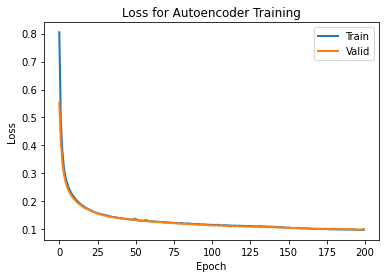

In [ ]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Loss for Autoencoder Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

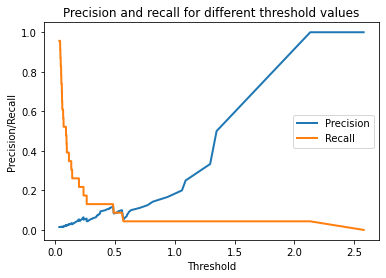

In [ ]:

X_valid_pred = autoencoder.predict(X_valid)
mse = np.mean(np.power(X_valid - X_valid_pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_valid['y']})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)

# Plot
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

Now, we will perform **classification on the test data**.

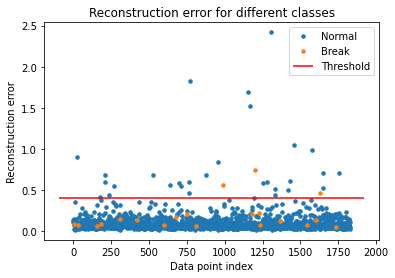

In [ ]:
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': df_test['y']})

error_df_test = error_df_test.reset_index()
threshold_fixed = 0.4
groups = error_df_test.groupby('True_class')

# Plot error
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

The orange and blue dots above the threshold line represents the True Positive and False Positive, respectively.

## *Confusion Matrix*

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1808
           1       0.09      0.15      0.11        20

    accuracy                           0.97      1828
   macro avg       0.54      0.57      0.55      1828
weighted avg       0.98      0.97      0.98      1828



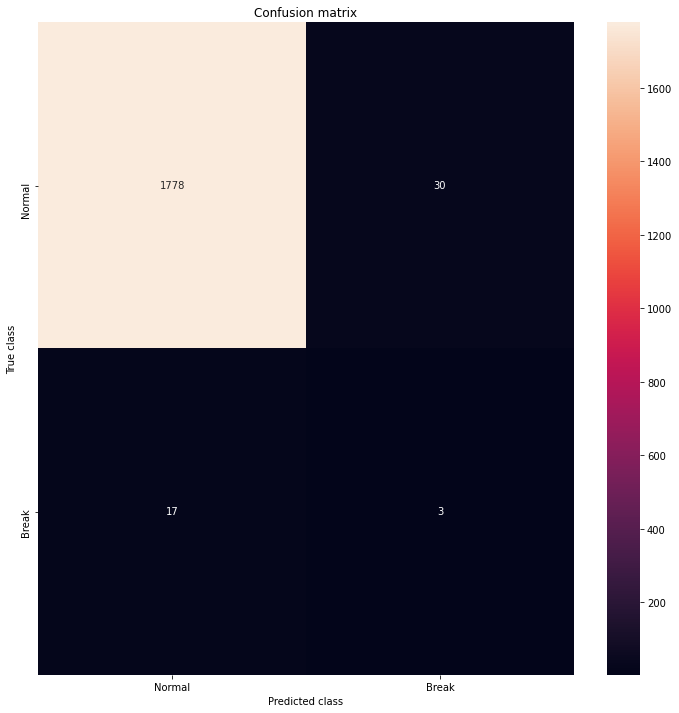

In [ ]:
LABELS = ["Normal","Break"]

# Test mode
error_df = error_df_test

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

# Print classification report
class_report = classification_report(error_df.True_class, pred_y)
print(class_report)

# Plot confusion matrix
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## *ROC curve*

AUC is desirable for the following two reasons:

* AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.
* AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.

However, both these reasons come with caveats, which may limit the usefulness of AUC in certain use cases:

* Scale invariance is not always desirable. For example, sometimes we really do need well calibrated probability outputs, and AUC won’t tell us about that.

* Classification-threshold invariance is not always desirable. In cases where there are wide disparities in the cost of false negatives vs. false positives, it may be critical to minimize one type of classification error. 

For example, when doing email spam detection, you likely want to prioritize minimizing false positives (even if that results in a significant increase of false negatives). AUC isn't a useful metric for this type of optimization.

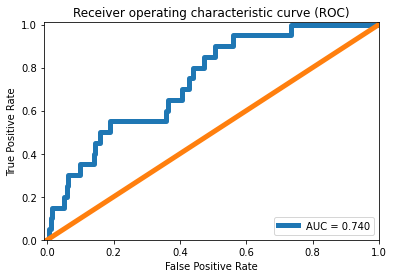

In [ ]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)


plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Feature Engineering

## Define Mahalanobis One Class

In [ ]:
from scipy.stats import chi2
import scipy as sp

def mahalanobis(x=None, data=None, cov=None):
    """
    Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data).values.reshape(1,-1) #np.mean(data)
    
    if not cov:
        cov = np.cov(data.values.T)
    if cov.shape == (): #Maha in 1 dimension
        cov = cov.reshape(1,1)
    inv_covmat = sp.linalg.inv(cov)
   
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

class MahalanobisOneclassClassifier():
    def __init__(self, xtrain, significance_level=0.01):
        self.xtrain = xtrain
        self.critical_value = chi2.ppf((1-significance_level), df=xtrain.shape[1]-1)
        #print('Critical value is: ', self.critical_value)

    def predict_prob(self, xtest):
        mahalanobis_dist = mahalanobis(xtest, self.xtrain)
        self.pvalues = 1 - chi2.cdf(mahalanobis_dist, 2)
        return mahalanobis_dist

    def predict(self, xtest):
        return np.array([int(i) for i in self.predict_proba(xtest) > self.critical_value])

## *XGBoost for feature importance*

The idea is to divide the features into affinity groups. This is done with the Gradient Boost Tree

In [ ]:
y = df['y']
X = df.drop(['y'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

gbc = XGBClassifier(n_estimators=1000,subsample=0.9,max_depth=6,random_state=10, max_features=0.9,n_jobs=2)
gbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              max_features=0.9, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=2, nthread=None,
              objective='binary:logistic', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9, verbosity=1)

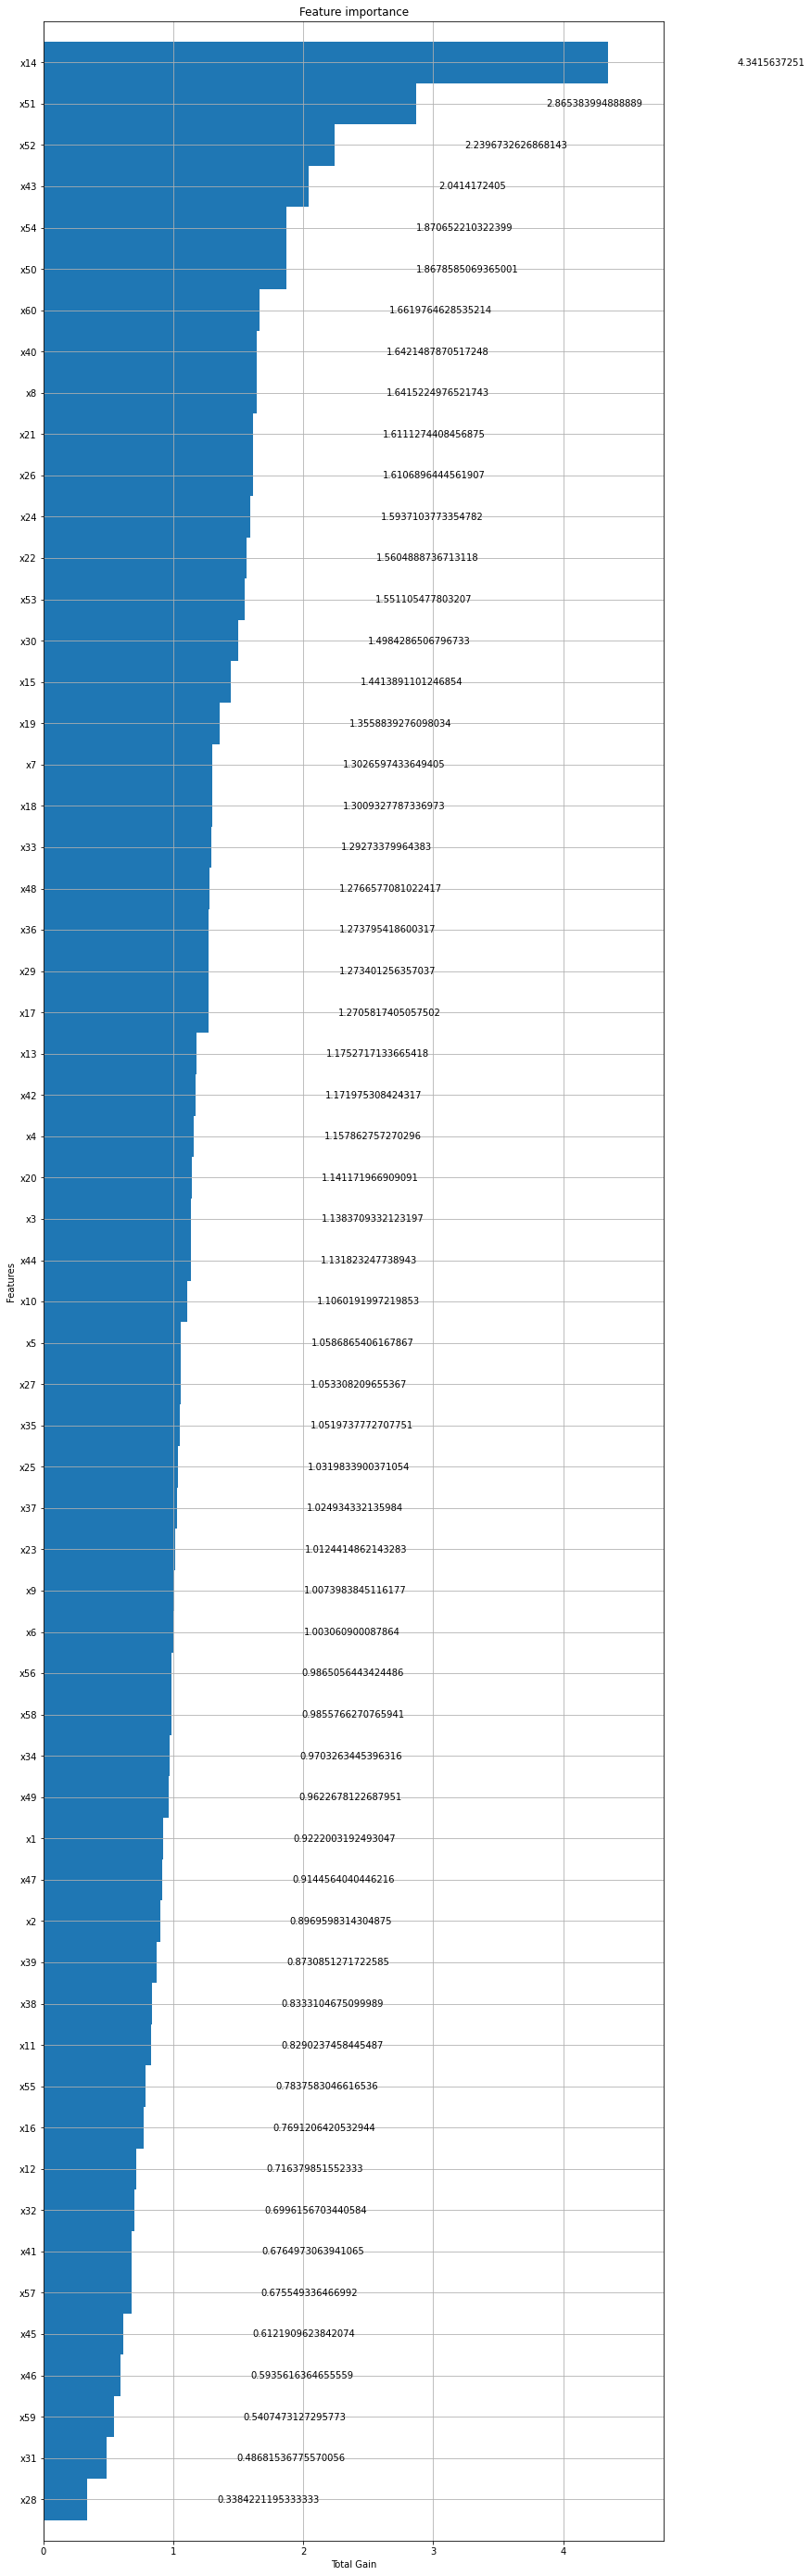

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,50))
plot_importance(gbc, ax=ax, height=1, importance_type="gain", xlabel="Total Gain")

By using the top 20 tags, separating them into 2-tag groups and calculating the SVM in a one class approach, we artificially created 10 new features that represent the distance from the standard operation of training data.

In [ ]:
add_1 = ['x14', 'x51']
add_2 = ['x52', 'x43']
add_3 = ['x54', 'x50']
add_4 = ['x60', 'x40']
add_5 = ['x8', 'x21']
add_6 = ['x26', 'x24']
add_7 = ['x22', 'x53']
add_8 = ['x30', 'x15']
add_9 = ['x19', 'x7']
add_10 = ['x18', 'x33']

# Models             
clf = MahalanobisOneclassClassifier(X_train[add_1])
clf2 = MahalanobisOneclassClassifier(X_train[add_2])
clf3 = MahalanobisOneclassClassifier(X_train[add_3])
clf4 = MahalanobisOneclassClassifier(X_train[add_4])
clf5 = MahalanobisOneclassClassifier(X_train[add_5])
clf6 = MahalanobisOneclassClassifier(X_train[add_6])
clf7 = MahalanobisOneclassClassifier(X_train[add_7])
clf8 = MahalanobisOneclassClassifier(X_train[add_8])
clf9 = MahalanobisOneclassClassifier(X_train[add_9])
clf10 = MahalanobisOneclassClassifier(X_train[add_10])

print("The models are trained...")

#stacking 
df['add_1'] = clf.predict_prob(df[add_1].values)
df['add_2'] = clf2.predict_prob(df[add_2].values)
df['add_3'] = clf3.predict_prob(df[add_3].values)
df['add_4'] = clf4.predict_prob(df[add_4].values)
df['add_5'] = clf5.predict_prob(df[add_5].values)
df['add_6'] = clf6.predict_prob(df[add_6].values)
df['add_7'] = clf7.predict_prob(df[add_7].values)
df['add_8'] = clf8.predict_prob(df[add_8].values)
df['add_9'] = clf9.predict_prob(df[add_9].values)
df['add_10'] = clf10.predict_prob(df[add_10].values)

df.head()

The models are trained...


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,add_1,add_2,add_3,add_4,add_5,add_6,add_7,add_8,add_9,add_10
0,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,-0.038189,0.877951,-0.052959,-13.306135,0.101068,0.041800,0.199901,-2.327329,-0.944167,3.075199,0.123154,-0.104334,-0.570710,-9.784456,0.355960,15.842819,-0.451973,-0.105282,96,-134.27786,0.058726,-0.021645,9.366755,0.002151,-69.187583,4.232571,-0.225267,-0.196872,-0.072449,-0.103732,-0.720746,-5.412436,76.679042,-0.632727,1351.63286,-0.657096,-0.434947,-108.77597,0.084856,10.210182,11.295155,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0.362519,2.585909,4.578406,1.584118,0.564492,0.256721,0.433247,1.575357,0.534463,5.625613
1,0,0.475720,-4.542502,-4.018359,16.230659,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,-0.038189,0.873273,-0.014244,-13.306135,0.101108,0.041447,0.304313,-2.340627,-0.939994,3.075199,0.123154,-0.104334,-0.574861,-9.784456,0.360160,16.491684,-0.450450,-0.092430,96,-134.48019,0.058759,-0.004579,9.350215,0.002149,-68.585197,4.311490,-0.225267,-0.196872,-0.059103,-0.083895,-0.720746,-8.343222,78.181598,-0.632727,1370.37895,-0.875629,-1.125819,-108.84897,0.085146,12.534340,11.290761,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0.362809,2.588105,4.577276,1.587194,0.564492,0.255337,0.440901,1.554112,0.534463,5.621769
2,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,-0.018352,1.004910,0.065150,-9.619596,0.101148,0.041095,0.252839,-2.353925,-0.935824,3.075199,0.123154,-0.104334,-0.579013,-9.784456,0.364356,15.972885,-0.448927,-0.097144,96,-133.94659,0.058791,-0.084658,9.037409,0.002148,-67.838187,4.809914,-0.225267,-0.186801,-0.048696,-0.073823,-0.720746,-1.085166,79.684154,-0.632727,1368.12309,-0.037775,-0.519541,-109.08658,0.085436,18.582893,11.286366,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0.363100,2.590431,4.576148,1.590274,0.564492,0.253959,0.448639,1.533116,0.510132,5.624548
3,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,-0.008280,0.930037,-0.067199,-15.196531,0.101188,0.040742,0.072873,-2.367223,-0.931651,3.075199,0.123154,-0.104334,-0.583165,-9.784456,0.368556,15.608688,-0.447404,-0.160073,96,-134.00259,0.058824,-0.055118,9.020625,0.002146,-67.091148,5.308343,-0.225267,-0.186801,-0.047017,-0.063752,-0.720746,6.172891,81.186702,-0.632727,1365.69145,-0.987410,0.674524,-109.56277,0.085726,17.719032,11.281972,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0.363391,2.592758,4.575021,1.593359,0.564492,0.252591,0.456441,1.512270,0.530182,5.620722
4,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,-0.008280,0.828410,-0.018472,-14.609266,0.101229,0.040390,0.171033,-2.380521,-0.927478,3.075199,0.123154,-0.104334,-0.587316,-9.784456,0.372756,15.606125,-0.445879,-0.131630,96,-133.14571,0.058856,-0.153851,9.344233,0.002145,-65.991813,5.806771,-0.225267,-0.186801,-0.057088,-0.063752,-0.720746,-3.379599,82.689258,-0.632727,1363.25786,-0.238445,-0.063044,-110.03891,0.086016,16.855202,11.277577,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0.363689,2.595087,4.573895,1.596890,0.564492,0.251229,0.464343,1.491671,0.534463,5.623529


In [ ]:
y = df['y']
X = df.drop(['y'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

gbc = XGBClassifier(n_estimators=1000,subsample=0.9,max_depth=6,random_state=10, max_features=0.9,n_jobs=2)
gbc.fit(X_train,y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              max_features=0.9, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=2, nthread=None,
              objective='binary:logistic', random_state=10, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.9, verbosity=1)

In [ ]:
print(classification_report(y_test,gbc.predict(X_test)))
confusion_matrix(y_test,gbc.predict(X_test))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1808
           1       0.00      0.00      0.00        20

    accuracy                           0.99      1828
   macro avg       0.49      0.50      0.50      1828
weighted avg       0.98      0.99      0.98      1828



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1808,    0],
       [  20,    0]])